# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)


import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator

import pyaldata as pyal

%matplotlib inline

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    defs = params.monkey_defs
    
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root
    reload(defs)
    reload(dt)
    reload(params) 

finally:
    os.chdir(nbPath)

if "__file__" not in dir():
    %run "_dataset-selection.ipynb"

the variable `GoodDataList` contains the session names


In [2]:
def get_data_array(data_list: list[pd.DataFrame], epoch_L: int =None , area: str ='M1', model=None) -> np.ndarray:   
    if isinstance(data_list, pd.DataFrame):
        data_list = [data_list]
    if isinstance(model, int):
        model = PCA(n_components=model, svd_solver='full')
    
    field = f'{area}_rates'
    n_shared_trial = np.inf
    target_ids = np.unique(data_list[0].target_id)
    for df in data_list:
        for target in target_ids:
            df_ = pyal.select_trials(df, df.target_id== target)
            n_shared_trial = np.min((df_.shape[0], n_shared_trial))

    n_shared_trial = int(n_shared_trial)

    # finding the number of timepoints
    n_timepoints = int(df_[field][0].shape[0])
    # n_timepoints = int(df_[field][0].shape[0])
    if epoch_L is None:
        epoch_L = n_timepoints
    else:
        assert epoch_L < n_timepoints, 'Epoch longer than data'
    
    # pre-allocating the data matrix
    AllData = np.zeros((len(data_list), len(target_ids), n_shared_trial, epoch_L, model.n_components))

    for session, df in enumerate(data_list):
        rates = np.concatenate(df_[field].values, axis=0)
        rates -= np.mean(rates, axis=0)
        rates_model = model.fit(rates)
        df_ = pyal.apply_dim_reduce_model(df_, rates_model, field, '_pca');

        for targetIdx,target in enumerate(target_ids):
            df__ = pyal.select_trials(df_, df_.target_id==target)
            all_id = df__.trial_id.to_numpy()
            # to guarantee shuffled ids
            params.rng.shuffle(all_id)
            # select the right number of trials to each target
            df__ = pyal.select_trials(df__, lambda trial: trial.trial_id in all_id[:n_shared_trial])
            for trial, trial_rates in enumerate(df__._pca):
                time_idx = params.rng.integers(trial_rates.shape[0]-epoch_L)
                while not np.isfinite(trial_data := trial_rates[time_idx:time_idx+epoch_L,:]).all():
                    time_idx = params.rng.integers(trial_rates.shape[0]-epoch_L)
                AllData[session,targetIdx,trial, :, :] = trial_data

    return AllData

reading data

In [3]:
full_list_MCx = []
for animal, sessionList in GoodDataList[defs.areas[2]].items():
    if 'Mr' in animal:
        continue  # to remove MrT
    full_list_MCx.append((animal,sessionList))
full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
# load the DFs
warnings.filterwarnings("ignore")
allDFs_MCx = []
for animal, session in full_list_MCx:
    path = root/animal/session
    allDFs_MCx.append(defs.prep_general(dt.load_pyal_data(path)))

## across animal, within area, across epochs, shuffled targets

so in short: different animals, different behaviours.

In [4]:
single_FileList1 = []
for I, (animal1,session1) in enumerate(full_list_MCx):
    for J, (animal2,session2) in enumerate(full_list_MCx):
        if J<=I or animal1 == animal2: continue  # to repetitions
        if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
        single_FileList1.append((I,J))

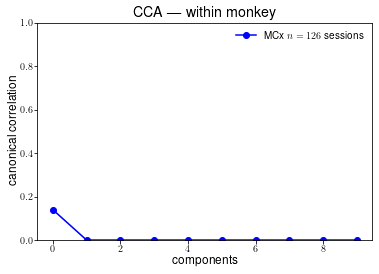

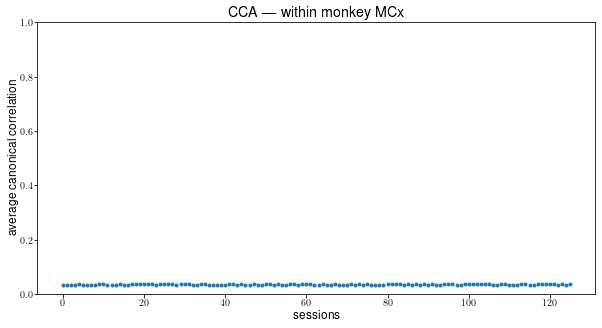

In [5]:
n_iter = params.n_iter * 10

len_trial = int(np.round(np.diff(defs.WINDOW_exec)/defs.BIN_SIZE))

#MCx
side1df = [allDFs_MCx[i] for i,_ in single_FileList1]
side2df = [allDFs_MCx[j] for _,j in single_FileList1]
warnings.filterwarnings("ignore")
AllData1  = get_data_array(side1df, epoch_L=len_trial, area=defs.areas[2], model=defs.n_components)
AllData1_ = get_data_array(side2df, epoch_L=len_trial, area=defs.areas[2], model=defs.n_components)
_,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData1_.shape),axis=0)

warnings.filterwarnings("default")

inCCs0=[]
for sessionData1,sessionData2 in zip(AllData1,AllData1_):
    r = []
    for n in range(n_iter):
        sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
        sessionData2_sh = params.rng.permutation(sessionData2,axis=0)

        data1 = np.reshape(sessionData1_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
        r.append(dt.canoncorr(data1, data2))
    inCCs0.append(r)
inCCs0 = np.array(inCCs0)
CC_lower_bound_MCx = np.percentile(inCCs0, 1, axis=1).T


# plotting
if "__file__" not in dir():
    _,ax = plt.subplots()

    utility.shaded_errorbar(ax, CC_lower_bound_MCx, color='b', marker = 'o', label=f'{defs.areas[2]} $n={CC_lower_bound_MCx.shape[1]}$ sessions')
    ax.set_ylim([0,1])
    ax.set_xlabel('components')
    ax.legend()
    ax.set_ylabel('canonical correlation')
    ax.set_title('CCA --- within monkey', usetex=True);

    fig,ax = plt.subplots(ncols=1, figsize=(10,5))
    ax.plot(CC_lower_bound_MCx[:4,:].mean(axis=0),'.')
    ax.set_ylabel('average canonical correlation')
    ax.set_title(f'CCA --- within monkey {defs.areas[2]} ', usetex=True);
    ax.set_ylim([0,1])
    ax.set_xlabel('sessions')